In [ ]:
!pip uninstall --yes --quiet  tensorflow-federated-nightly
!pip uninstall --yes --quiet  nest-asyncio
!pip install  --quiet --upgrade tensorflow-federated-nightly
!pip install  --quiet --upgrade nest-asyncio

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
nbclient 0.5.4 requires jupyter-client>=6.1.5, but you have jupyter-client 5.3.5 which is incompatible.


In [ ]:
import tensorflow_federated as tff
import tensorflow as tf
import numpy as np
import collections
import nest_asyncio
import platform
import time

nest_asyncio.apply()
(x, y), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

# normalization
x=tf.image.per_image_standardization(x)
x_test=tf.image.per_image_standardization(x_test)

# standardization
# x, x_test = x / 255.0, x_test / 255.0
print(tf.__version__)
print(tff.__version__)
print(platform.python_version())

2.7.0-dev20210824
0.19.0
3.7.11


In [ ]:
NUM_CLIENTS = 100
total_image_count = len(x)
image_per_set = int(np.floor(total_image_count/NUM_CLIENTS))
client_train_dataset = collections.OrderedDict()
client_test_dataset = collections.OrderedDict()
for i in range(1, NUM_CLIENTS+1):
    client_name = "client_" + str(i)
    start = image_per_set * (i-1)
    end = image_per_set * i
    data = collections.OrderedDict((('label', y[start:end]), ('pixels', x[start:end])))
    # test_data = collections.OrderedDict((('label', y_test[start:end]), ('pixels', x_test[start:end])))
    client_train_dataset[client_name] = data
    # client_test_dataset[client_name]= test_data


emnist_train = tff.simulation.datasets.TestClientData(client_train_dataset)
# emnist_test=tff.simulation.datasets.TestClientData(client_test_dataset)



In [ ]:

NUM_ROUNDS = 200
NUM_EPOCHS = 5
BATCH_SIZE = 16
SHUFFLE_BUFFER = 418
PREFETCH_BUFFER = 10
CLIENTS_PER_ROUND=5
server_lr=1.0
client_lr=0.01
def preprocess(dataset):
  def batch_format_fn(element):
    return collections.OrderedDict(
        x=tf.expand_dims(element['pixels'], -1), y=element['label'])
  return dataset.map(batch_format_fn).repeat(NUM_EPOCHS).shuffle(SHUFFLE_BUFFER).batch(
      BATCH_SIZE).prefetch(PREFETCH_BUFFER)



In [ ]:
def create_keras_model():
  
  model = tf.keras.models.Sequential()
  model.add(tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28,28,1)))
  model.add(tf.keras.layers.MaxPooling2D((2, 2)))
  model.add(tf.keras.layers.Conv2D(64, (3, 3), activation='relu'))
  model.add(tf.keras.layers.MaxPooling2D((2, 2)))
  model.add(tf.keras.layers.Conv2D(64, (3, 3), activation='relu'))
  model.add(tf.keras.layers.Flatten())
  model.add(tf.keras.layers.Dense(64, activation='relu'))
  model.add(tf.keras.layers.Dense(10))
  return model
  
example_dataset = emnist_train.create_tf_dataset_for_client(
    emnist_train.client_ids[0])
preprocessed_example_dataset = preprocess(example_dataset)
def model_fn():
  keras_model = create_keras_model()
  return tff.learning.from_keras_model(
      keras_model,
    input_spec=preprocessed_example_dataset.element_spec ,
      loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
      metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])
      
iterative_process = tff.learning.build_federated_averaging_process(
    model_fn,
    client_optimizer_fn=lambda: tf.keras.optimizers.Adam(),
    server_optimizer_fn=lambda: tf.keras.optimizers.Adam(),
    use_experimental_simulation_loop=True
    )


In [ ]:
state = iterative_process.initialize()
start_time = time.time()
rounds=[]
acc=[]
for round_num in range(1, NUM_ROUNDS):
  sampled_clients = np.random.choice(
    emnist_train.client_ids,
    size=CLIENTS_PER_ROUND,
    replace=False)
  sampled_train_data = [
    preprocess(emnist_train.create_tf_dataset_for_client(x))
  for x in sampled_clients
  ]
  state, metrics = iterative_process.next(state, sampled_train_data)
  rounds.append(round_num)
  acc.append(metrics["train"]["sparse_categorical_accuracy"])
  print(f'Round {round_num} training loss: {round(metrics["train"]["loss"], 5) } sparse_categorical_accuracy: {round(metrics["train"]["sparse_categorical_accuracy"],5)}, '
  f'time: {round((time.time()-start_time)/(round_num+1.))} secs')

Instructions for updating:
Use `tf.compat.v1.graph_util.extract_sub_graph`


Instructions for updating:
Use `tf.compat.v1.graph_util.extract_sub_graph`


Round 1 training loss: 1.5062099695205688 sparse_categorical_accuracy: 0.548799991607666, time: 26 secs
Round 2 training loss: 0.42473000288009644 sparse_categorical_accuracy: 0.8712700009346008, time: 24 secs
Round 3 training loss: 0.22520999610424042 sparse_categorical_accuracy: 0.9317299723625183, time: 23 secs
Round 4 training loss: 0.16651000082492828 sparse_categorical_accuracy: 0.953000009059906, time: 23 secs
Round 5 training loss: 0.1392900049686432 sparse_categorical_accuracy: 0.9607300162315369, time: 22 secs
Round 6 training loss: 0.10806000232696533 sparse_categorical_accuracy: 0.9684699773788452, time: 22 secs
Round 7 training loss: 0.10696999728679657 sparse_categorical_accuracy: 0.9670699834823608, time: 22 secs
Round 8 training loss: 0.08603999763727188 sparse_categorical_accuracy: 0.9777299761772156, time: 22 secs
Round 9 training loss: 0.098580002784729 sparse_categorical_accuracy: 0.9718700051307678, time: 22 secs
Round 10 training loss: 0.07838000357151031 sparse_c

In [ ]:
def make_federated_data(client_data, client_ids):
  return [
      preprocess(client_data.create_tf_dataset_for_client(x))
      for x in client_ids
  ]

OrderedDict([('eval', OrderedDict([('sparse_categorical_accuracy', 0.994), ('loss', 0.018559812)])), ('stat', OrderedDict([('num_examples', 15000)]))])


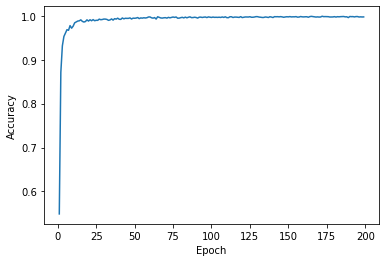

"OrderedDict([('eval', OrderedDict([('sparse_categorical_accuracy', 0.994), ('loss', 0.018559812)])), ('stat', OrderedDict([('num_examples', 15000)]))])"

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

sampled_clients = np.random.choice(
  emnist_train.client_ids,
  size=CLIENTS_PER_ROUND,
  replace=False)
# build train data for selected clients

evaluation = tff.learning.build_federated_evaluation(model_fn)
federated_train_data= make_federated_data(emnist_train, sampled_clients)
train_metrics = evaluation(state.model, federated_train_data)
print(str(train_metrics))
# federated_test_data = make_federated_data(emnist_test, sampled_clients)
# test_metrics = evaluation(state.model, federated_test_data)

plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.plot(rounds,acc,label='Epoch')
# plt.legend(loc='lower right')
plt.show()
 
# test_loss, test_acc = model.evaluate(test_images, test_labels, verbose=2)

str(train_metrics)